In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 377.0MB 40kB/s 


It: 0, Loss: 2.487e-01, Time: 4.86
It: 100, Loss: 1.080e-01, Time: 5.29
It: 200, Loss: 3.567e-02, Time: 5.20
It: 300, Loss: 9.057e-03, Time: 5.19
It: 400, Loss: 3.241e-03, Time: 5.20
It: 500, Loss: 1.453e-03, Time: 5.19
It: 600, Loss: 9.204e-04, Time: 5.19
It: 700, Loss: 6.105e-04, Time: 5.19
It: 800, Loss: 4.166e-04, Time: 5.21
It: 900, Loss: 3.330e-04, Time: 5.21
Loss: 2.545e-04
Loss: 5.475e+00
Loss: 2.542e-04
Loss: 2.545e-04
Loss: 2.539e-04
Loss: 2.537e-04
Loss: 2.537e-04
Loss: 2.540e-04
Loss: 2.537e-04
Loss: 2.532e-04
Loss: 2.540e-04
Loss: 2.536e-04
Loss: 2.532e-04
Loss: 2.537e-04
Loss: 2.537e-04
Loss: 2.532e-04
Loss: 2.536e-04
Loss: 2.532e-04
Loss: 2.532e-04
Loss: 2.536e-04
Loss: 2.532e-04
Loss: 2.536e-04
Loss: 2.532e-04
Loss: 2.532e-04
Loss: 2.532e-04
Loss: 2.536e-04
Loss: 2.532e-04
Loss: 2.532e-04
Loss: 2.532e-04
Loss: 2.532e-04
Loss: 2.532e-04
Loss: 2.532e-04
Loss: 2.542e-04
Loss: 2.530e-04
Loss: 2.545e-04
Loss: 2.537e-04
Loss: 2.536e-04
Loss: 2.530e-04
Loss: 2.530e-04
Loss: 2.

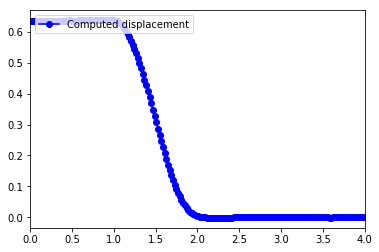

In [0]:
    # MAIN PINN Tensorflow python code 
    # Author : Tittu Varghese Mathew, in collaboration with Sundar, Hrishikesh and Pramod 
    # Date : 6th September 2019 
    # Reference paper : An Energy Approach to the Solution of Partial Differential
    # Equations in Computational Mechanics via Machine Learning: Concepts, Implementation and Applications

    # Import the necessary packages 
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.io
    from scipy.interpolate import griddata
    import time
    from itertools import product, combinations
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.gridspec as gridspec
    import pylab
    import math 
    from operator import add
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # To set the random seed number to a fixed value so that 
    # every time you run the code, same random numbering will be generated 
    # for replication purposes
    np.random.seed(1234)
    tf.set_random_seed(1234)

    class PhysicsInformedNN:
        # Initialize the class
        # Xcoord,Ycoord,cbnodes,layers,c11,c12,c33,DArea,Npoints,P,Nb
        def __init__(self, layers,u0,v0,L,T,XTp,Nx, Nt, g, Tpoints, c):        
            
            self.layers = layers            # Bottom boundary nodes 
            self.XTp = XTp
            # print(XTp.shape)
            NPoints = XTp.shape[0]
            self.x = XTp[:,0:1]
            self.t = XTp[:,1:2]
            
            #self.xtensor = tf.convert_to_tensor(self.x, dtype=tf.float32)
            #self.ttensor = tf.convert_to_tensor(self.t, dtype=tf.float32)
            
            self.lb = XTp.min(0)  		                # Find the minimum value in all columns
            self.ub = XTp.max(0)			            # Find the maximum value in all columns 
            self.layers = layers        
            self.weights, self.biases = self.initialize_NN(self.layers)          
            self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True))              
            self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
            self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
            
            self.u, self.u_x, self.u_t, self.u_xx, self.u_tt = self.elastodynamics(self.x_tf,self.t_tf)
            
            # Reshape 
            self.u_reshape = tf.reshape(self.u, [Nt, Nx])
            self.ux_reshape = tf.reshape(self.u_x, [Nt, Nx])
            self.ut_reshape = tf.reshape(self.u_t, [Nt, Nx])
            self.uxx_reshape = tf.reshape(self.u_xx, [Nt, Nx])
            self.utt_reshape = tf.reshape(self.u_tt, [Nt, Nx])
            
            # MSE_init      : MSE at initial time  
            u_hat_init = self.u_reshape[0,:]
            u0_init = u0 * np.ones(Nx)
            u0_init_tensor = tf.convert_to_tensor(u0_init, dtype=tf.float32)
            ut_hat_init = self.ut_reshape[0,:]
            v0_init = v0 * np.ones(Nx)
            v0_init_tensor = tf.convert_to_tensor(v0_init, dtype=tf.float32)
            MSE_init_part1 = tf.multiply(tf.reduce_sum(tf.math.square(tf.math.subtract(u_hat_init,u0_init_tensor))),(1/Nx))
            MSE_init_part2 = tf.multiply(tf.reduce_sum(tf.math.square(tf.math.subtract(ut_hat_init,v0_init_tensor))),(1/Nx))
            MSE_init = MSE_init_part1 + MSE_init_part2 
            
            
            # MSE_bnd  
            u_hat_L_t = self.u_reshape[:,-1]
            g_L_t = g * np.ones(Nt)
            g_L_t_tensor = tf.convert_to_tensor(g_L_t, dtype=tf.float32)
            MSE_bnd_part2 = tf.multiply(tf.reduce_sum(tf.math.square(tf.math.subtract(u_hat_L_t,g_L_t_tensor))),(1/Nt))
            ux_hat_0_t = self.ux_reshape[:,0]
            u_bar = np.zeros(Nt)
            u_bar_indx = np.nonzero(Tpoints <= 1)       # <- here, the '1' sec time is user defined  
            indxx = u_bar_indx[0]
            for ii in indxx: 
                u_bar[ii] = -1 * math.sin(math.pi*Tpoints[ii])
            u_bar_tensor = tf.convert_to_tensor(u_bar, dtype=tf.float32)                
            MSE_bnd_part1 = tf.multiply(tf.reduce_sum(tf.math.square(tf.math.subtract(ux_hat_0_t,u_bar_tensor))),(1/Nt))
            MSE_bnd = MSE_bnd_part1 + MSE_bnd_part2            
            
            # MSE_resid     : MSE of residual at internal collocation points 
            uxx_red = self.uxx_reshape[1:,1:-1]
            utt_red = self.utt_reshape[1:,1:-1]
            Nint = (Nt-1)*(Nx-2)
            MSE_resid = tf.multiply(tf.reduce_sum(tf.math.square(tf.math.subtract(utt_red,(c**2)*uxx_red))),(1/Nint))
            
            self.loss = MSE_init + MSE_bnd + MSE_resid 
            
            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,method='L-BFGS-B',options={'maxiter': 50000,'maxfun': 50000,'maxcor': 50,'maxls': 50,'ftol' : 1.0 * np.finfo(float).eps})        
            self.optimizer_Adam = tf.train.AdamOptimizer()
            self.train_op_Adam = self.optimizer_Adam.minimize(self.loss) 
            
            init = tf.global_variables_initializer()
            self.sess.run(init)
            
        ############################################################################
        ####### Class function definition to initialize the weights and biases #####
        ############################################################################
        def initialize_NN(self,layers):        
            # Pass in the layer information 
            weights = [] 		       
            biases = []        
            num_layers = len(layers)    		
            for l in range(0,num_layers-1):
                W = self.xavier_init(size=[layers[l], layers[l+1]])
                b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)	               
                weights.append(W)
                biases.append(b)        			
            # Both W and b are tf.Variables 
            return weights, biases
        
        ############################################################################
        #######  Function to define the initial weights of ANN #####################
        ############################################################################    
        def xavier_init(self,size):
            in_dim = size[0]
            out_dim = size[1]        
            xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))                
            return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
        
        ########################################################################
        ##############   Function to calculate the variational energy ##########
        ########################################################################
        def elastodynamics(self,x,t):
            u = self.net_ut(x,t)             
            u_x = tf.gradients(u,x)[0]
            u_t = tf.gradients(u,t)[0]            
            u_xx = tf.gradients(u_x,x)[0]
            u_tt = tf.gradients(u_t,t)[0]                                  
            return u , u_x , u_t, u_xx , u_tt
               
        ########################################################################
        ####### Class function to impose the boundary conditions  ##############
        ########################################################################
        def net_ut(self,x,t):  ## <- what is vdelta  ?? 
            XT = tf.concat([x,t] ,1)     # Concatenate the 'x' and 'y' coordinates 
            u = self.neural_net(XT,self.weights,self.biases)
            return u
            
        ############################################################################
        ###########    Neural Network design #######################################
        ############################################################################
        def neural_net(self, X, weights, biases):
            num_layers = len(weights) + 1		   
            H = 2.0 * (X - self.lb) / ( self.ub - self.lb) - 1.0
            for l in range(0,num_layers-2):
                W = weights[l]
                b = biases[l]
                H = tf.nn.relu(tf.add(tf.matmul(H,W),b))**2   
            W = weights[-1]
            b = biases[-1]
            return tf.add(tf.matmul(H, W), b)  # Last layer consists of only linear activation
        
        ############################################################################
        #########    Function call to train ANN  ###################################
        ############################################################################
        def train(self, nIter): 
            tf_dict = {self.x_tf: self.x, self.t_tf: self.t}        
            start_time = time.time()        
            for it in range(nIter):
                self.sess.run(self.train_op_Adam,tf_dict)            
                if it % 100 == 0:
                    elapsed = time.time() - start_time
                    loss_value = self.sess.run(self.loss, tf_dict)
                    print('It: %d, Loss: %.3e, Time: %.2f' % 
                          (it, loss_value, elapsed))
                    start_time = time.time()  

            self.optimizer.minimize(self.sess,feed_dict = tf_dict,fetches = [self.loss],loss_callback = self.callback)

        ############################################################################
        ##########     Function to perform prediction   ############################
        ############################################################################
        def predict(self,TimePlot,Nx,Nt,Tpoints):
            tf_dict = {self.x_tf: self.x, self.t_tf: self.t}        
            u_star = self.sess.run(self.u, tf_dict)
            v_star = self.sess.run(self.u_t, tf_dict)
            
            u_reshape = np.reshape(u_star, [Nt, Nx])
            v_reshape = np.reshape(v_star, [Nt, Nx])
            
            idx1 = np.nonzero(Tpoints==TimePlot)
            idx = idx1[0][0]
                        
            u_send = u_reshape[idx,:]
            v_send = v_reshape[idx,:]
            
            return u_send, v_send
        
        def callback(self, loss):
            print('Loss: %.3e' % (loss))

    ###############################################################################        
    #******************               MAIN file                     **************#
    ###############################################################################
    if __name__ == "__main__": 
        
        L = 4        # Length of the domain 
        T = 2        # Total time duration 
        c = 1        # Wave propagation speed
        u0 = 0       # Initial displacement 
        v0 = 0       # Initial velocity   
        g = 0        # Dirichlet bc on right end of 1D domain
        
        # Neural network architecture 
        # 2 inputs corresponds to 'x' and 't' dimensions 
        # 1 ouput corresponds to 'u' displacements
        # 3 hidden layers each having 30 neurons
        layers = [2, 50, 50, 50, 1]
        Niter = 1000      # Number of iterations/epoch for training 
        
        # Creat collocation points across the domain
        Nx = 200;      # Number of collocation points along the spatial dimenaion
        Nt = 200;      # Number of collocation points along the time dimension  
        Xpoints = np.linspace(0,L,Nx)
        Tpoints = np.linspace(0,T,Nt)
        
        count = 0
        XTp = np.zeros([Nx*Nt,2])
        
        for i in range(0,Nt):
            for j in range(0,Nx):
                XTp[count][0] = XTp[count][0] + Xpoints[j]
                XTp[count][1] = XTp[count][1] + Tpoints[i]
                count = count + 1    
        
        # Create a class object of type PhysiceInformedNN
        model = PhysicsInformedNN(layers,u0,v0,L,T,XTp,Nx, Nt,g, Tpoints, c)
        model.train(Niter)   		
        
        ############################################################################
        #############    Time to plot the solution   ###############################
        ############################################################################
        # Prediction
        TimePlot = 2
        u_pred, v_pred = model.predict(TimePlot,Nx, Nt, Tpoints)
        
        # Plot the displacement solution at t = TimePlot 
        Xpoints = np.array(Xpoints).T
        pylab.plot(Xpoints,u_pred,'-bo',label='Computed displacement')
        #pylab.plot(Xpoints,v_pred,'-ro', label='Computed velcoty')
        pylab.legend(loc='upper left')
        #pylab.ylim(0,u1)
        pylab.xlim(0,L)
        pylab.show()       
        
        